In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class cnn_5Layers(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3,stride=1,padding=1),   # 3*224*224 -> 16*224*224
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),   # 16*224*224 -> 16*112*112
            nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1),   # 16*112*112 -> 32*112*112
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)  # 32*112*112 -> 32*56*56
        )
        self.classifier = nn.Sequential(
            nn.Linear(32*56*56, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_class)
        )

    def forward(self,x):
        x = self.features(x)
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        return x

In [3]:
class cnn_6Layers(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3,stride=1,padding=1),   # 3*224*224 -> 16*224*224
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),   # 16*224*224 -> 16*112*112
            nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1),   # 16*112*112 -> 32*112*112
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),   # 32*112*112 -> 64*112*112
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)  # 64*112*112 -> 64*56*56
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*56*56, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_class)
        )

    def forward(self,x):
        x = self.features(x)
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        return x

In [4]:
def predict_single_image(model, image_tensor, device, class_names, top_k=3):
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        top_probs, top_indices = torch.topk(probabilities, k=top_k, dim=1)
        
        top_probs = top_probs.cpu().numpy()[0]
        top_indices = top_indices.cpu().numpy()[0]
        
        predictions = []
        for i, (idx, prob) in enumerate(zip(top_indices, top_probs)):
            predictions.append({
                'rank': i+1,
                'class_index': idx,
                'class_name': class_names[idx],
                'probability': prob
            })
        
        return predictions

In [32]:
def display_prediction_results(original_image, predictions, class_names):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    ax1.imshow(original_image)
    ax1.set_title('Input image', fontsize=14)
    ax1.axis('off')
    
    classes = [p['class_name'] for p in predictions]
    probabilities = [p['probability'] for p in predictions]
    colors = plt.cm.viridis(np.linspace(0, 1, len(predictions)))
    
    bars = ax2.barh(classes, probabilities, color=colors)
    ax2.set_xlabel('probabilities', fontsize=12)
    ax2.set_title('Prediction (Top {})'.format(len(predictions)), fontsize=14)
    ax2.set_xlim(0, 1)
    
    for i, (bar, prob) in enumerate(zip(bars, probabilities)):
        width = bar.get_width()
        ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{prob:.4f}', ha='left', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    for pred in predictions:
        print(f"{pred['rank']}. {pred['class_name']}: {pred['probability']:.4f} ({pred['probability']*100:.2f}%)")
    
    top_pred = predictions[0]
    print(f"\nPest prediction results: {top_pred['class_name']} (probabilities: {top_pred['probability']:.4f})")

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
num_class = 12
path_best = "model_pth/6-001-128.pth"
model_best = cnn_6Layers(num_class)
dict_best = torch.load(path_best)
model_best.load_state_dict(dict_best)
model_best.to(device)
model_best.eval()

cnn_5Layers(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=100352, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=12, bias=True)
  )
)

In [22]:
def predict_show(model, image_path, device):    
    class_names = ["Ants","Bees","Beetles","Caterpillars","Earthworms","Earwigs","Grasshoppers","Moths","Slugs","Snails","Wasps","Weevils"]
    
    transformer = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])

    image = Image.open(image_path).convert('RGB')
    original_image = image.copy()
    image_tensor = transformer(image).unsqueeze(0)
    
    predictions = predict_single_image(model, image_tensor, device, class_names, top_k=3)
    display_prediction_results(original_image, predictions, class_names)

The result of failure


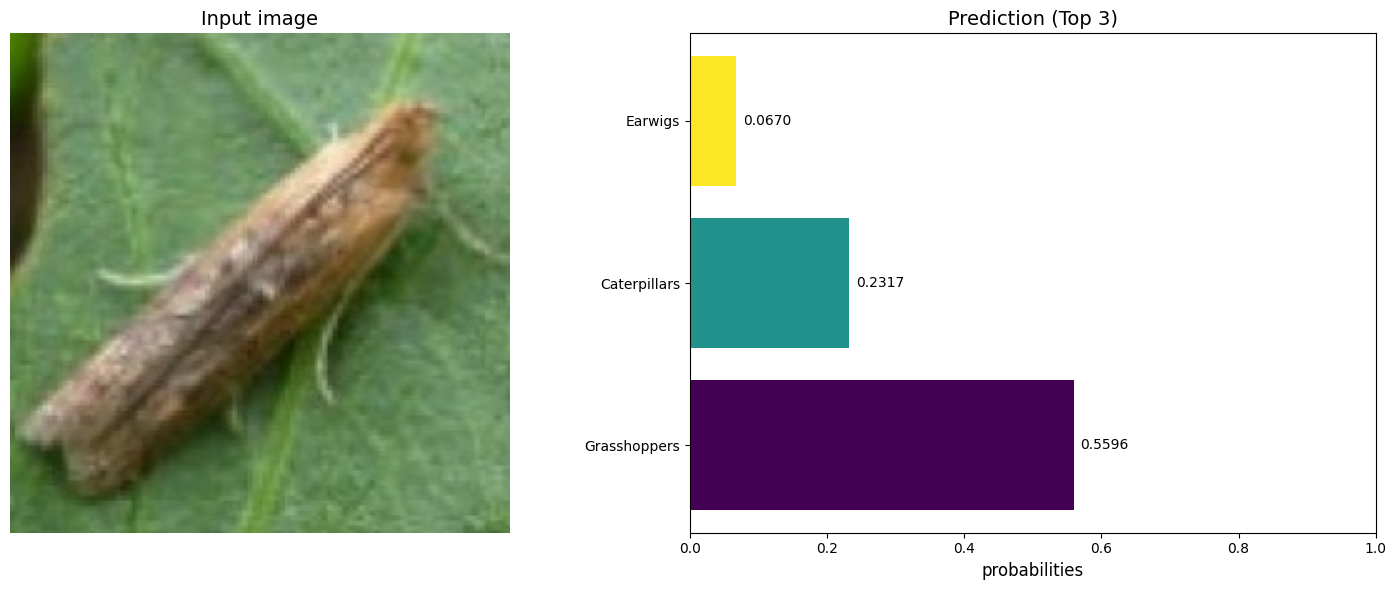

1. Grasshoppers: 0.5596 (55.96%)
2. Caterpillars: 0.2317 (23.17%)
3. Earwigs: 0.0670 (6.70%)

Pest prediction results: Grasshoppers (probabilities: 0.5596)
**********************************************************************


The result of correct


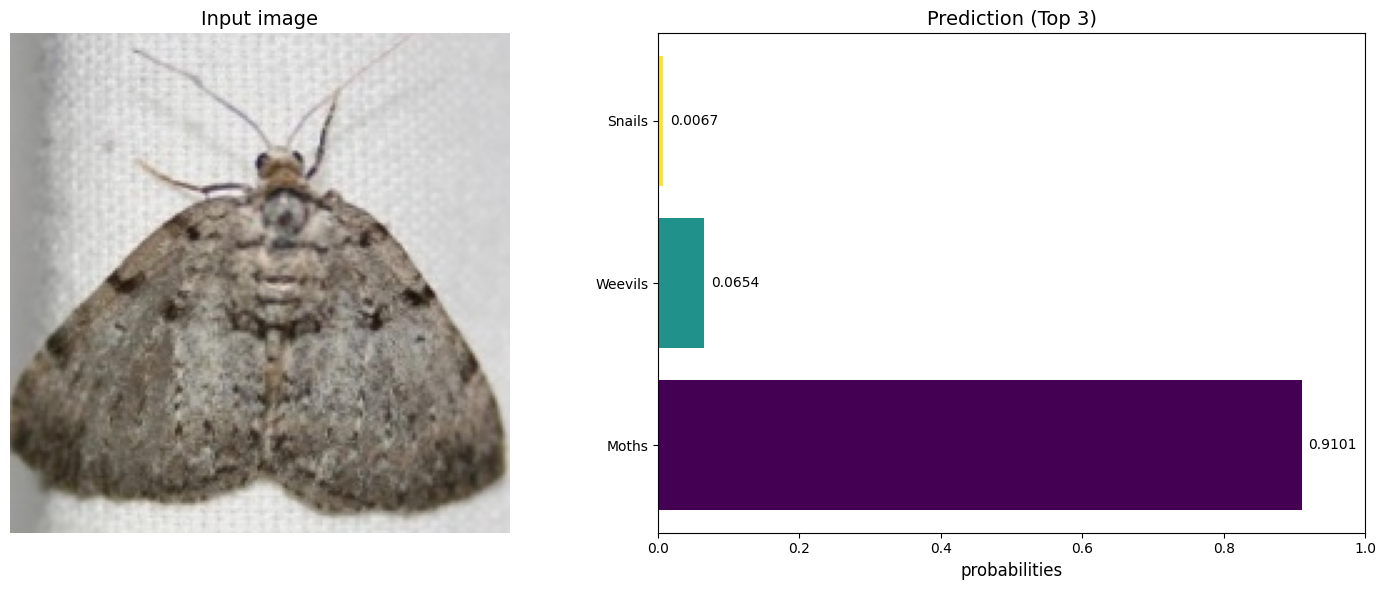

1. Moths: 0.9101 (91.01%)
2. Weevils: 0.0654 (6.54%)
3. Snails: 0.0067 (0.67%)

Pest prediction results: Moths (probabilities: 0.9101)


In [41]:
image_path1 = "Recognized/test/Moths/moth-457-_jpg.rf.66efd23244193f0876f40fe1a64713ce_bbox0.jpg"
image_path2 = "Recognized/test/Moths/moth-43-_jpg.rf.151ca77c476f95158198c48caeb8e12d_bbox0.jpg"

print("The result of failure")
predict_show(model_best, image_path1, device)
print('*'*70)
print('\n')
print("The result of correct")
predict_show(model_best, image_path2, device)